## Plots for matura arbeit

### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import re

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
files = glob.glob("data/**/*.csv", recursive=True)
files

['data\\base\\cfg_base_run_1.csv',
 'data\\base\\cfg_base_run_2.csv',
 'data\\base\\cfg_base_run_3.csv',
 'data\\base\\cfg_base_run_4.csv',
 'data\\base\\cfg_base_run_5.csv',
 'data\\ga_only\\cfg_ga_only_run_1.csv',
 'data\\ga_only\\cfg_ga_only_run_2.csv',
 'data\\ga_only\\cfg_ga_only_run_3.csv',
 'data\\ga_only\\cfg_ga_only_run_4.csv',
 'data\\ga_only\\cfg_ga_only_run_5.csv',
 'data\\gen_q_learning\\cfg_gen_q_learning_run_1.csv',
 'data\\gen_q_learning\\cfg_gen_q_learning_run_2.csv',
 'data\\gen_q_learning\\cfg_gen_q_learning_run_3.csv',
 'data\\gen_q_learning\\cfg_gen_q_learning_run_4.csv',
 'data\\gen_q_learning\\cfg_gen_q_learning_run_5.csv',
 'data\\q_only\\cfg_q_only_run_1.csv',
 'data\\q_only\\cfg_q_only_run_2.csv',
 'data\\q_only\\cfg_q_only_run_3.csv',
 'data\\q_only\\cfg_q_only_run_4.csv',
 'data\\q_only\\cfg_q_only_run_5.csv']

### Dataframe loading

In [3]:
data = []
for f in files:
    df = pd.read_csv(f)
    filename = os.path.basename(f)

    match = re.match(r"cfg_(.+)_run_(\d+)\.csv", filename)
    if match:
        cfg_name, run_id = match.groups()
    else:
        cfg_name, run_id = "unknown", None

    # df["config"] = cfg_name
    if run_id and int(run_id) <= 5:
        df["repetition"] = int(run_id) if run_id else None
        data.append(df)
df_all = pd.concat(data, ignore_index=True)
df_all

,config,log_type,mean_fitness_alive,n_alive,run_id,seed,time,wave,damage,dodged_bullets,enemy_id,fitness,lifespan,repetition
0,base,wave_snapshot,0.099071,4.0,1,43559,1.000000,1,NaN,NaN,NaN,NaN,NaN,1
1,base,wave_snapshot,0.197935,8.0,1,43559,2.000000,1,NaN,NaN,NaN,NaN,NaN,1
2,base,wave_snapshot,0.296488,12.0,1,43559,3.000000,1,NaN,NaN,NaN,NaN,NaN,1
3,base,wave_snapshot,0.420148,15.0,1,43559,4.000000,1,NaN,NaN,NaN,NaN,NaN,1
4,base,wave_snapshot,0.619076,15.0,1,43559,5.000000,1,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8795,q_only,wave_snapshot,9.771128,3.0,18,710768,28.000000,10,NaN,NaN,NaN,NaN,NaN,5
8796,q_only,wave_snapshot,9.971112,3.0,18,710768,29.000000,10,NaN,NaN,NaN,NaN,NaN,5
8797,q_only,death,NaN,NaN,18,710768,30.002406,10,1.0,0.0,142.0,12.640510,28.202550,5
8798,q_only,death,NaN,NaN,18,710768,30.002406,10,1.0,0.0,143.0,12.589480,27.947398,5


### Intra Wave Plots

#### Q-learning vs Base: time vs fitness.

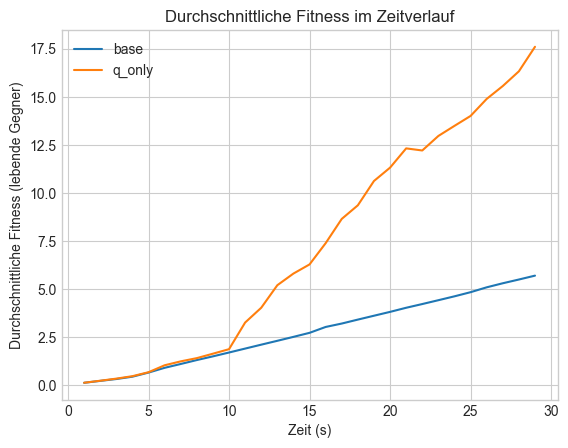

In [4]:

subset = df_all[
    (df_all["config"].isin(["q_only", "base"])) &
    (df_all["log_type"] == "wave_snapshot") 
    # (df_all['repetition'] == 1)
]

# group by both config and time
grouped = subset.groupby(["config", "time"])["mean_fitness_alive"].mean().reset_index()

# plot both
for cfg in ["base", "q_only"]:
    df_cfg = grouped[grouped["config"] == cfg]
    plt.plot(df_cfg["time"], df_cfg["mean_fitness_alive"], label=cfg)

plt.title("Durchschnittliche Fitness im Zeitverlauf")
plt.xlabel("Zeit (s)")
plt.ylabel("Durchschnittliche Fitness (lebende Gegner)")
plt.legend()
plt.show()

### Across Wave plots

All configs: wave vs fitness

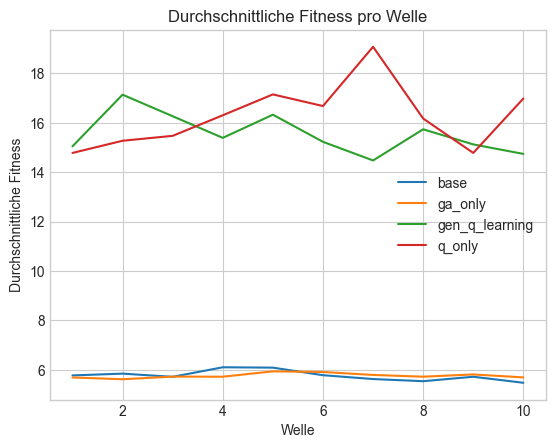

In [5]:
# subset = df_all[(df_all["repetition"] == 1)]
wave_avg = df_all.groupby(["config", "wave"])["fitness"].mean().reset_index()
for cfg in wave_avg["config"].unique():
    plt.plot(
        wave_avg[wave_avg["config"] == cfg]["wave"],
        wave_avg[wave_avg["config"] == cfg]["fitness"],
        label=cfg
    )
plt.title("Durchschnittliche Fitness pro Welle")
plt.xlabel("Welle")
plt.ylabel("Durchschnittliche Fitness")
plt.legend()
plt.show()

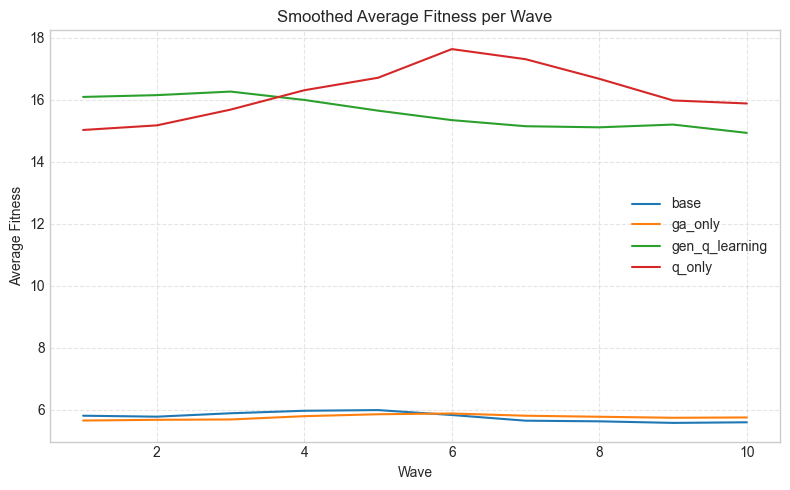

In [6]:
# Apply smoothing per config
window = 3  # you can increase this to make it smoother
wave_avg["smoothed_fitness"] = (
    wave_avg.groupby("config")["fitness"]
    .transform(lambda x: x.rolling(window, center=True, min_periods=1).mean())
)

# Plot all configs
plt.figure(figsize=(8, 5))
for cfg in wave_avg["config"].unique():
    cfg_data = wave_avg[wave_avg["config"] == cfg]
    plt.plot(cfg_data["wave"], cfg_data["smoothed_fitness"], label=cfg)

plt.title("Smoothed Average Fitness per Wave")
plt.xlabel("Wave")
plt.ylabel("Average Fitness")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

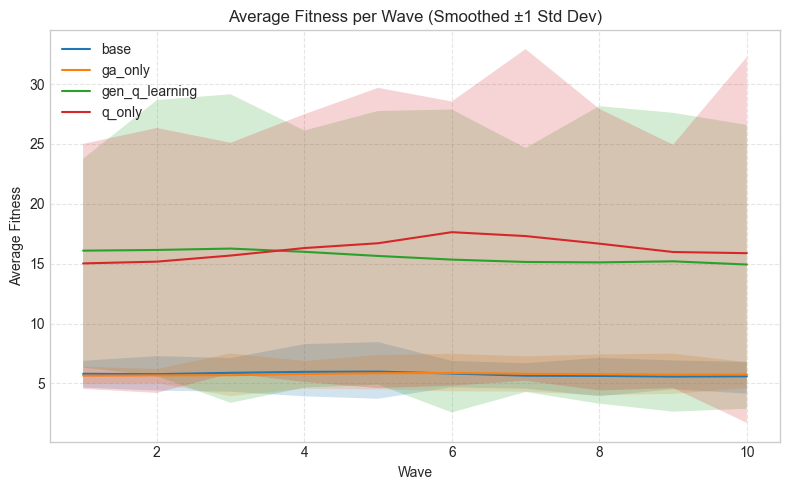

In [7]:
# smoother with standard deviation
# Compute mean and std
wave_stats = df_all.groupby(["config", "wave"])["fitness"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(8, 5))
for cfg in wave_stats["config"].unique():
    data = wave_stats[wave_stats["config"] == cfg]
    # Smooth mean
    smooth_mean = data["mean"].rolling(3, center=True, min_periods=1).mean()
    plt.plot(data["wave"], smooth_mean, label=cfg)
    plt.fill_between(data["wave"], data["mean"] - data["std"], data["mean"] + data["std"], alpha=0.2)

plt.title("Average Fitness per Wave (Smoothed ±1 Std Dev)")
plt.xlabel("Wave")
plt.ylabel("Average Fitness")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Curiosities

wave vs damage

40


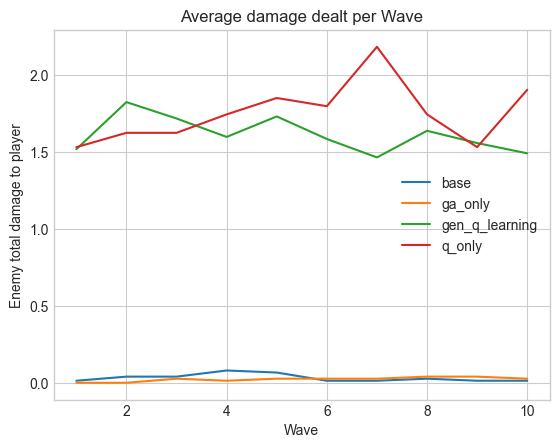

In [8]:
wave_avg = df_all.groupby(["config", "wave"])["damage"].mean().reset_index()
print(len(wave_avg))
for cfg in wave_avg["config"].unique():
    plt.plot(
        wave_avg[wave_avg["config"] == cfg]["wave"],
        wave_avg[wave_avg["config"] == cfg]["damage"],
        label=cfg
    )
plt.title("Average damage dealt per Wave")
plt.xlabel("Wave")
plt.ylabel("Enemy total damage to player")
plt.legend()
plt.show()

wave vs dodging

40


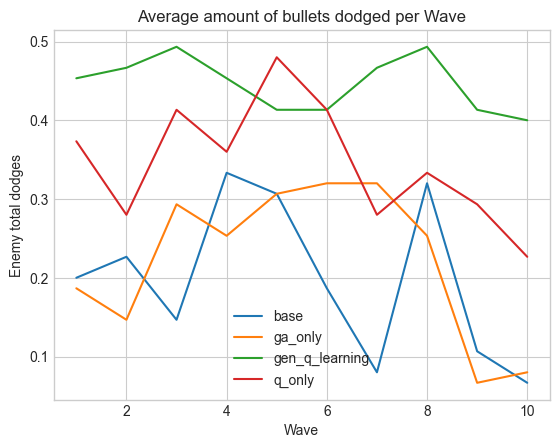

In [9]:
wave_avg = df_all.groupby(["config", "wave"])["dodged_bullets"].mean().reset_index()
print(len(wave_avg))
for cfg in wave_avg["config"].unique():
    plt.plot(
        wave_avg[wave_avg["config"] == cfg]["wave"],
        wave_avg[wave_avg["config"] == cfg]["dodged_bullets"],
        label=cfg
    )
plt.title("Average amount of bullets dodged per Wave")
plt.xlabel("Wave")
plt.ylabel("Enemy total dodges")
plt.legend()
plt.show()